In [1]:
import os
import torch
import json
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import utils, transforms
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision
from PIL import Image, ImageOps
import copy

In [2]:
train_json_path = 'annot/train.json'
test_json_path = 'annot/test.json'
val_json_path = 'annot/valid.json'
images_path = 'images'

In [3]:
with open(train_json_path) as f:
    train_json = json.load(f)
# with open(test_json_path) as f:
#     test_json = json.load(f)
with open(val_json_path) as f:
    test_json = json.load(f)

In [4]:
train_images = []
train_scales = []
train_centers = []
train_joints_vis = []
train_joints = []
for img in train_json:
    train_images.append(img['image'])
    train_scales.append(img['scale'])
    train_centers.append(img['center'])
    train_joints_vis.append(img['joints_vis'])
    train_joints.append(img['joints'])
train_joints = np.asarray(train_joints)

In [5]:
test_images = []
test_scales = []
test_centers = []
test_joints_vis = []
test_joints = []
for img in test_json:
    test_images.append(img['image'])
    test_scales.append(img['scale'])
    test_centers.append(img['center'])
    test_joints_vis.append(img['joints_vis'])
    test_joints.append(img['joints'])
test_joints = np.asarray(test_joints)

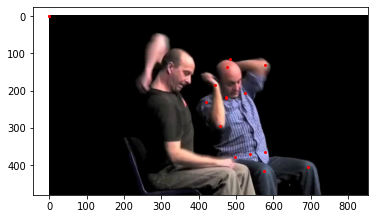

In [6]:
def show_landmarks(image, landmarks):
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=15, marker='.', c='r')
    plt.pause(0.001)

plt.figure()
index = 20
show_landmarks(io.imread(os.path.join(images_path, train_images[index])), train_joints[index])
plt.show()

In [52]:
class PoseDataset(Dataset):
    def __init__(self, images, labels, scales, centers, root_dir, transform=None):

        self.images = images
        self.landmarks = labels
        self.scales = scales
        self.centers = centers
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks)

    def crop_man(self, sample, scale_man, center_man):
        image, landmarks = sample[0], sample[1]

        h, w = image.shape[:2]
        
        h_add, v_add = 0, 0

        top = int(center_man[1] - scale_man*105)
        if top < 0:
            h_add = int(-top)
            top = 0
        left = int(center_man[0] - scale_man*60)
        if left < 0:
            v_add = int(-left)
            left = 0

        image = image[top: top + int(scale_man*210) - h_add,
                      left: left + int(scale_man*120) - v_add]

        landmarks = landmarks - [left, top]
        for i, landmark in enumerate(landmarks):
            if landmark[0] < 0 or landmark[1] < 0:
                landmarks[i] = [-1, -1]

        return (image, landmarks)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()       
        img_name = os.path.join(self.root_dir,
                                self.images[idx])
        print(img_name)
        image = io.imread(img_name)
        landmarks = self.landmarks[idx]
        sample = (image, landmarks)
        scale_man = self.scales[idx]
        center_man = self.centers[idx]

        sample = self.crop_man(sample, scale_man, center_man)

        if self.transform:
            sample = self.transform(sample)
          
            if type(sample[0]) == torch.Tensor:
                norm = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                norm(sample[0])

        return sample

In [53]:
class Resize(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image = sample

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            new_h, new_w = self.output_size, self.output_size
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)
        img = transform.resize(image, (new_h, new_w))
        return img

class ToTensor(object):
    def __call__(self, sample):
        image = sample
        image = image.transpose((2, 0, 1))
#         image = image.astype('float32')
        return torch.from_numpy(image)

class SquarePad(object):
  def __init__(self, targetSize):
    self.targetSize = int(targetSize)

  def __call__(self, sample):
    image = sample
    targetSize = self.targetSize

    if max(image.shape) < targetSize:
      image = Image.fromarray(image)
      old_size = image.size

      ratio = float(targetSize)/max(old_size)
      new_size = tuple([int(x*ratio) for x in old_size])

      image = image.resize(new_size, Image.ANTIALIAS)
      image = np.asarray(image)

    image = image.transpose((2, 0, 1))
    image = torch.from_numpy(image)
    c, h, w = image.shape

    hp, vp = 0, 0
    if w < targetSize:
      hp = int((targetSize - w) / 2)
    if h < targetSize:
      vp = int((targetSize - h) / 2)
    padding = (hp, hp, vp, vp)
  
    image = F.pad(image, padding, 'constant', 0).numpy()
    image = image.transpose((1, 2, 0))
    return image

In [54]:
pose_dataset = PoseDataset(images=train_images, labels=train_joints, scales=train_scales,
                           centers=train_centers, root_dir=images_path,
                           transform=transforms.Compose([SquarePad(256), Resize(256), ToTensor()]))
# pose_dataset = PoseDataset(images=train_images, labels=train_joints, scales=train_scales,
#                            centers=train_centers, root_dir=images_path,
#                            transform=transforms.Compose([Resize(256), ToTensor()]))

In [55]:
test_data = PoseDataset(images=test_images, labels=test_joints, scales=test_scales,
                           centers=test_centers, root_dir=images_path,
                           transform=transforms.Compose([SquarePad(256), Resize(256), ToTensor()]))
test_loader = DataLoader(test_data, batch_size=32, shuffle=True, num_workers=2)

In [56]:
plt.figure()
toImg = transforms.ToPILImage()
index = 89
show_landmarks(toImg(test_data[index][0].type(torch.FloatTensor)), test_data[index][1])
plt.show()

images/022197216.jpg


AttributeError: 'tuple' object has no attribute 'shape'

<Figure size 432x288 with 0 Axes>

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc92e3d89d0>
Traceback (most recent call last):
  File "/home/user/anaconda3/envs/sentimentanalysis/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/home/user/anaconda3/envs/sentimentanalysis/lib/python3.8/site-packages/torch/utils/data/dataloader.py", line 1297, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/home/user/anaconda3/envs/sentimentanalysis/lib/python3.8/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/home/user/anaconda3/envs/sentimentanalysis/lib/python3.8/multiprocessing/popen_fork.py", line 44, in wait
    if not wait([self.sentinel], timeout):
  File "/home/user/anaconda3/envs/sentimentanalysis/lib/python3.8/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/home/user/anaconda3/envs/sentimentanalysis/li

In [57]:
train_data, val_data = torch.utils.data.random_split(pose_dataset, [20000, 2246])
train_loader = DataLoader(train_data, batch_size=4, shuffle=True, num_workers=8)
val_loader = DataLoader(val_data, batch_size=24, shuffle=True, num_workers=8)

In [71]:
class BnReluConv(nn.Module):
		"""docstring for BnReluConv"""
		def __init__(self, inChannels, outChannels, kernelSize = 1, stride = 1, padding = 0):
				super(BnReluConv, self).__init__()
				self.inChannels = inChannels
				self.outChannels = outChannels
				self.kernelSize = kernelSize
				self.stride = stride
				self.padding = padding

				self.bn = nn.BatchNorm2d(self.inChannels)
				self.conv = nn.Conv2d(self.inChannels, self.outChannels, self.kernelSize, self.stride, self.padding)
				self.relu = nn.ReLU()

		def forward(self, x):
				x = self.bn(x)
				x = self.relu(x)
				x = self.conv(x)
				return x


class ConvBlock(nn.Module):
		"""docstring for ConvBlock"""
		def __init__(self, inChannels, outChannels):
				super(ConvBlock, self).__init__()
				self.inChannels = inChannels
				self.outChannels = outChannels
				self.outChannelsby2 = outChannels//2

				self.cbr1 = BnReluConv(self.inChannels, self.outChannelsby2, 1, 1, 0)
				self.cbr2 = BnReluConv(self.outChannelsby2, self.outChannelsby2, 3, 1, 1)
				self.cbr3 = BnReluConv(self.outChannelsby2, self.outChannels, 1, 1, 0)

		def forward(self, x):
				x = self.cbr1(x)
				x = self.cbr2(x)
				x = self.cbr3(x)
				return x

class SkipLayer(nn.Module):
		"""docstring for SkipLayer"""
		def __init__(self, inChannels, outChannels):
				super(SkipLayer, self).__init__()
				self.inChannels = inChannels
				self.outChannels = outChannels
				if (self.inChannels == self.outChannels):
						self.conv = None
				else:
						self.conv = nn.Conv2d(self.inChannels, self.outChannels, 1)

		def forward(self, x):
				if self.conv is not None:
						x = self.conv(x)
				return x

class Residual(nn.Module):
		"""docstring for Residual"""
		def __init__(self, inChannels, outChannels):
				super(Residual, self).__init__()
				self.inChannels = inChannels
				self.outChannels = outChannels
				self.cb = ConvBlock(inChannels, outChannels)
				self.skip = SkipLayer(inChannels, outChannels)

		def forward(self, x):
				out = 0
				out = out + self.cb(x)
				out = out + self.skip(x)
				return out
            
class myUpsample(nn.Module):
	def __init__(self):
		super(myUpsample, self).__init__()
		pass
	def forward(self, x):
		return x[:, :, :, None, :, None].expand(-1, -1, -1, 2, -1, 2).reshape(x.size(0), x.size(1), x.size(2)*2, x.size(3)*2)
        
        
class Hourglass(nn.Module):
    """docstring for Hourglass"""
    def __init__(self, nChannels = 256, numReductions = 4, nModules = 2, poolKernel = (2,2), poolStride = (2,2), upSampleKernel = 2):
        super(Hourglass, self).__init__()
        self.numReductions = numReductions
        self.nModules = nModules
        self.nChannels = nChannels
        self.poolKernel = poolKernel
        self.poolStride = poolStride
        self.upSampleKernel = upSampleKernel
        """
        For the skip connection, a residual module (or sequence of residuaql modules)
        """

        _skip = []
        for _ in range(self.nModules):
            _skip.append(Residual(self.nChannels, self.nChannels))

        self.skip = nn.Sequential(*_skip)

        """
        First pooling to go to smaller dimension then pass input through
        Residual Module or sequence of Modules then  and subsequent cases:
            either pass through Hourglass of numReductions-1
            or pass through Residual Module or sequence of Modules
        """

        self.mp = nn.MaxPool2d(self.poolKernel, self.poolStride)

        _afterpool = []
        for _ in range(self.nModules):
            _afterpool.append(Residual(self.nChannels, self.nChannels))

        self.afterpool = nn.Sequential(*_afterpool)

        if (numReductions > 1):
            self.hg = Hourglass(self.nChannels, self.numReductions-1, self.nModules, self.poolKernel, self.poolStride)
        else:
            _num1res = []
            for _ in range(self.nModules):
                _num1res.append(Residual(self.nChannels,self.nChannels))

            self.num1res = nn.Sequential(*_num1res)  # doesnt seem that important ?

        """
        Now another Residual Module or sequence of Residual Modules
        """

        _lowres = []
        for _ in range(self.nModules):
            _lowres.append(Residual(self.nChannels,self.nChannels))

        self.lowres = nn.Sequential(*_lowres)

        """
        Upsampling Layer (Can we change this??????)
        As per Newell's paper upsamping recommended
        """
        self.up = myUpsample()#nn.Upsample(scale_factor = self.upSampleKernel)


    def forward(self, x):
        out1 = x
        out1 = self.skip(out1)
        out2 = x
        out2 = self.mp(out2)
        out2 = self.afterpool(out2)
        if self.numReductions>1:
            out2 = self.hg(out2)
        else:
            out2 = self.num1res(out2)
        out2 = self.lowres(out2)
        out2 = self.up(out2)

        return out2 + out1


class StackedHourGlass(nn.Module):
	"""docstring for StackedHourGlass"""
	def __init__(self, nChannels, nStack, nModules, numReductions, nJoints):
		super(StackedHourGlass, self).__init__()
		self.nChannels = nChannels
		self.nStack = nStack
		self.nModules = nModules
		self.numReductions = numReductions
		self.nJoints = nJoints

		self.start = BnReluConv(3, 64, kernelSize = 7, stride = 2, padding = 3)

		self.res1 = Residual(64, 128)
		self.mp = nn.MaxPool2d(2, 2)
		self.res2 = Residual(128, 128)
		self.res3 = Residual(128, self.nChannels)

		_hourglass, _Residual, _lin1, _chantojoints, _lin2, _jointstochan = [],[],[],[],[],[]

		for _ in range(self.nStack):
			_hourglass.append(Hourglass(self.nChannels, self.numReductions, self.nModules))
			_ResidualModules = []
			for _ in range(self.nModules):
				_ResidualModules.append(Residual(self.nChannels, self.nChannels))
			_ResidualModules = nn.Sequential(*_ResidualModules)
			_Residual.append(_ResidualModules)
			_lin1.append(BnReluConv(self.nChannels, self.nChannels))
			_chantojoints.append(nn.Conv2d(self.nChannels, self.nJoints,1))
			_lin2.append(nn.Conv2d(self.nChannels, self.nChannels,1))
			_jointstochan.append(nn.Conv2d(self.nJoints,self.nChannels,1))

		self.hourglass = nn.ModuleList(_hourglass)
		self.Residual = nn.ModuleList(_Residual)
		self.lin1 = nn.ModuleList(_lin1)
		self.chantojoints = nn.ModuleList(_chantojoints)
		self.lin2 = nn.ModuleList(_lin2)
		self.jointstochan = nn.ModuleList(_jointstochan)

	def forward(self, x):
		x = self.start(x)
		x = self.res1(x)
		x = self.mp(x)
		x = self.res2(x)
		x = self.res3(x)
		out = []

		for i in range(self.nStack):
			x1 = self.hourglass[i](x)
			x1 = self.Residual[i](x1)
			x1 = self.lin1[i](x1)
			out.append(self.chantojoints[i](x1))
			x1 = self.lin2[i](x1)
			x = x + x1 + self.jointstochan[i](out[i])

		return (out)
    
class OurStackedHourGlass(nn.Module):
  def __init__(self, nChannels, nStack, nModules, numReductions, nJoints):
    super(OurStackedHourGlass, self).__init__()
    self.nChannels = nChannels
    self.nStack = nStack
    self.nModules = nModules
    self.numReductions = numReductions
    self.nJoints = nJoints

    self.first = BnReluConv(3, 64, kernelSize = 7, stride = 2, padding = 3)
    self.second = BnReluConv(64, 64, kernelSize = 3, stride = 1, padding = 1)
    self.third = BnReluConv(64, 128, kernelSize = 1, stride = 1, padding = 0)
    self.mp = nn.MaxPool2d(2, 2)
    self.fourth = BnReluConv(128, 128, kernelSize = 3, stride = 1, padding = 1)
    self.fifth = BnReluConv(128, self.nChannels, kernelSize = 1, stride = 1, padding = 0)

    _hourglass, _Residual, _lin1, _chantojoints, _lin2, _jointstochan = [],[],[],[],[],[]

    for _ in range(self.nStack):
      _hourglass.append(Hourglass(self.nChannels, self.numReductions, self.nModules))
      _ResidualModules = []
      for _ in range(self.nModules):
        _ResidualModules.append(Residual(self.nChannels, self.nChannels))
      _ResidualModules = nn.Sequential(*_ResidualModules)
      _Residual.append(_ResidualModules)
      _lin1.append(BnReluConv(self.nChannels, self.nChannels))
      _chantojoints.append(nn.Conv2d(self.nChannels, self.nJoints,1))
      _lin2.append(nn.Conv2d(self.nChannels, self.nChannels,1))
      _jointstochan.append(nn.Conv2d(self.nJoints,self.nChannels,1))

    self.hourglass = nn.ModuleList(_hourglass)
    self.Residual = nn.ModuleList(_Residual)
    self.lin1 = nn.ModuleList(_lin1)
    self.chantojoints = nn.ModuleList(_chantojoints)
    self.lin2 = nn.ModuleList(_lin2)
    self.jointstochan = nn.ModuleList(_jointstochan)

  def forward(self, x):
    x = self.first(x)
    x = self.second(x)
    x = self.third(x)
    x = self.mp(x)
    x = self.fourth(x)
    x = self.fifth(x)
    out = []

    for i in range(self.nStack):
      x1 = self.hourglass[i](x)
      x1 = self.Residual[i](x1)
      x1 = self.lin1[i](x1)
      out.append(self.chantojoints[i](x1))
      x1 = self.lin2[i](x1)
      x = x + x1 + self.jointstochan[i](out[i])

    return (out)


class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.stackedHG = OurStackedHourGlass(nChannels=256, nStack=2, nModules=2, numReductions=4, nJoints=16)

    def forward(self, x):
        x = self.stackedHG(x)
        return x

In [67]:
class HeatmapGenerator():
    def __init__(self, output_res, num_joints, sigma=-1):
        self.output_res = output_res
        self.num_joints = num_joints
        if sigma < 0:
            sigma = self.output_res/64
        self.sigma = sigma
        size = 6*sigma + 3
        x = np.arange(0, size, 1, float)
        y = x[:, np.newaxis]
        x0, y0 = 3*sigma + 1, 3*sigma + 1
        self.g = np.exp(- ((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2))

    def __call__(self, joints):
        hms = np.zeros((joints.shape[0], self.num_joints, self.output_res, self.output_res),
                       dtype=np.float64)
        sigma = self.sigma
        for i, p in enumerate(joints):
            for idx, pt in enumerate(p):
#                 if pt[2] > 0:
                    if pt[0] < 0 or pt[1] < 0 or \
                       pt[0] >= self.output_res*4 or pt[1] >= self.output_res*4:
                        continue
                    x, y = int(pt[0])//4, int(pt[1])//4

                    ul = int(np.round(x - 3 * sigma - 1)), int(np.round(y - 3 * sigma - 1))
                    br = int(np.round(x + 3 * sigma + 2)), int(np.round(y + 3 * sigma + 2))

                    c, d = max(0, -ul[0]), min(br[0], self.output_res) - ul[0]
                    a, b = max(0, -ul[1]), min(br[1], self.output_res) - ul[1]

                    cc, dd = max(0, ul[0]), min(br[0], self.output_res)
                    aa, bb = max(0, ul[1]), min(br[1], self.output_res)
                    hms[i, idx, aa:bb, cc:dd] = np.maximum(
                        hms[i, idx, aa:bb, cc:dd], self.g[a:b, c:d])
        return hms

In [68]:
heatmap = HeatmapGenerator(64, 16)
for batch_idx, (data, target) in enumerate(test_loader):
    print(target.shape)
    target = torch.from_numpy(heatmap(target))
    print(target.shape)
    break

images/092373140.jpg
images/012020723.jpg
images/042934274.jpg
images/026493089.jpg


AttributeError: Caught AttributeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/user/anaconda3/envs/sentimentanalysis/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 202, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/user/anaconda3/envs/sentimentanalysis/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/user/anaconda3/envs/sentimentanalysis/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/tmp/ipykernel_26487/3701816861.py", line 55, in __getitem__
    sample = self.transform(sample)
  File "/home/user/anaconda3/envs/sentimentanalysis/lib/python3.8/site-packages/torchvision/transforms/transforms.py", line 60, in __call__
    img = t(img)
  File "/tmp/ipykernel_26487/965076392.py", line 34, in __call__
    if max(image.shape) < targetSize:
AttributeError: 'tuple' object has no attribute 'shape'


images/042770117.jpg


In [43]:
class myUpsample(nn.Module):
	def __init__(self):
		super(myUpsample, self).__init__()
		pass
	def forward(self, x):
		return x[:, :, :, None, :, None].expand(-1, -1, -1, 2, -1, 2).reshape(x.size(0), x.size(1), x.size(2)*2, x.size(3)*2)
        
        
class Hourglass(nn.Module):
    """docstring for Hourglass"""
    def __init__(self, nChannels = 256, numReductions = 4, nModules = 2, poolKernel = (2,2), poolStride = (2,2), upSampleKernel = 2):
        super(Hourglass, self).__init__()
        self.numReductions = numReductions
        self.nModules = nModules
        self.nChannels = nChannels
        self.poolKernel = poolKernel
        self.poolStride = poolStride
        self.upSampleKernel = upSampleKernel
        """
        For the skip connection, a residual module (or sequence of residuaql modules)
        """

        _skip = []
        for _ in range(self.nModules):
            _skip.append(Residual(self.nChannels, self.nChannels))

        self.skip = nn.Sequential(*_skip)

        """
        First pooling to go to smaller dimension then pass input through
        Residual Module or sequence of Modules then  and subsequent cases:
            either pass through Hourglass of numReductions-1
            or pass through Residual Module or sequence of Modules
        """

        self.mp = nn.MaxPool2d(self.poolKernel, self.poolStride)

        _afterpool = []
        for _ in range(self.nModules):
            _afterpool.append(Residual(self.nChannels, self.nChannels))

        self.afterpool = nn.Sequential(*_afterpool)

        if (numReductions > 1):
            self.hg = Hourglass(self.nChannels, self.numReductions-1, self.nModules, self.poolKernel, self.poolStride)
        else:
            _num1res = []
            for _ in range(self.nModules):
                _num1res.append(Residual(self.nChannels,self.nChannels))

            self.num1res = nn.Sequential(*_num1res)  # doesnt seem that important ?

        """
        Now another Residual Module or sequence of Residual Modules
        """

        _lowres = []
        for _ in range(self.nModules):
            _lowres.append(Residual(self.nChannels,self.nChannels))

        self.lowres = nn.Sequential(*_lowres)

        """
        Upsampling Layer (Can we change this??????)
        As per Newell's paper upsamping recommended
        """
        self.up = myUpsample()#nn.Upsample(scale_factor = self.upSampleKernel)


    def forward(self, x):
        out1 = x
        out1 = self.skip(out1)
        out2 = x
        out2 = self.mp(out2)
        out2 = self.afterpool(out2)
        if self.numReductions>1:
            out2 = self.hg(out2)
        else:
            out2 = self.num1res(out2)
        out2 = self.lowres(out2)
        out2 = self.up(out2)

        return out2 + out1


class StackedHourGlass(nn.Module):
	"""docstring for StackedHourGlass"""
	def __init__(self, nChannels, nStack, nModules, numReductions, nJoints):
		super(StackedHourGlass, self).__init__()
		self.nChannels = nChannels
		self.nStack = nStack
		self.nModules = nModules
		self.numReductions = numReductions
		self.nJoints = nJoints

		self.start = BnReluConv(3, 64, kernelSize = 7, stride = 2, padding = 3)

		self.res1 = Residual(64, 128)
		self.mp = nn.MaxPool2d(2, 2)
		self.res2 = Residual(128, 128)
		self.res3 = Residual(128, self.nChannels)

		_hourglass, _Residual, _lin1, _chantojoints, _lin2, _jointstochan = [],[],[],[],[],[]

		for _ in range(self.nStack):
			_hourglass.append(Hourglass(self.nChannels, self.numReductions, self.nModules))
			_ResidualModules = []
			for _ in range(self.nModules):
				_ResidualModules.append(Residual(self.nChannels, self.nChannels))
			_ResidualModules = nn.Sequential(*_ResidualModules)
			_Residual.append(_ResidualModules)
			_lin1.append(BnReluConv(self.nChannels, self.nChannels))
			_chantojoints.append(nn.Conv2d(self.nChannels, self.nJoints,1))
			_lin2.append(nn.Conv2d(self.nChannels, self.nChannels,1))
			_jointstochan.append(nn.Conv2d(self.nJoints,self.nChannels,1))

		self.hourglass = nn.ModuleList(_hourglass)
		self.Residual = nn.ModuleList(_Residual)
		self.lin1 = nn.ModuleList(_lin1)
		self.chantojoints = nn.ModuleList(_chantojoints)
		self.lin2 = nn.ModuleList(_lin2)
		self.jointstochan = nn.ModuleList(_jointstochan)

	def forward(self, x):
		x = self.start(x)
		x = self.res1(x)
		x = self.mp(x)
		x = self.res2(x)
		x = self.res3(x)
		out = []

		for i in range(self.nStack):
			x1 = self.hourglass[i](x)
			x1 = self.Residual[i](x1)
			x1 = self.lin1[i](x1)
			out.append(self.chantojoints[i](x1))
			x1 = self.lin2[i](x1)
			x = x + x1 + self.jointstochan[i](out[i])

		return (out)

In [19]:
# def train(model, device, train_loader, optimizer, epoch):
#     model.train()
#     train_loss = 0
#     for batch_idx, (data, target) in enumerate(train_loader):
#         data, target = data.to(device), target.to(device)
#         optimizer.zero_grad()
#         output = model(data)
#         loss = 0
#         inx = np.zeros(output[0].shape)
#         for a in range(len(target)):
#             for b in range(len(target[a])):
#                 x = target[a][b][0].item()
#                 y = target[a][b][1].item()
#                 x, y = int(min(63, max(0, x//4))), int(min(63, max(0, y//4)))
#                 inx[a][b][x][y] = 1
#         inx = torch.from_numpy(inx).to(device)
        
#         for i in range(len(output)):
#             loss += F.mse_loss(output[i], inx)
#         #loss = F.mse_loss(output, target)
#         train_loss += loss.item()
#         loss.backward()
#         optimizer.step()
#         if batch_idx % 10 == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch+1, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item()))
#     train_loss_list.append(train_loss/len(train_loader))

# def train(model, device, train_loader, optimizer, epoch):
#     model.train()
#     train_loss = 0
#     for batch_idx, (data, target) in enumerate(train_loader):
#         data, target = data.to(device), target.to(device)
#         optimizer.zero_grad()
#         output = model(data)
#         loss = 0
#         inx = np.zeros(output[0].shape)
#         for a in range(len(target)):
#             for b in range(len(target[a])):
#                 x = target[a][b][0].item()
#                 y = target[a][b][1].item()
#                 x, y = int(min(63, max(0, x//4))), int(min(63, max(0, y//4)))
#                 inx[a][b][x][y] = 1
#         inx = torch.from_numpy(inx).to(device)
        
#         for i in range(len(output)):
#             loss += F.mse_loss(output[i], inx)
#         #loss = F.mse_loss(output, target)
#         train_loss += loss.item()
#         loss.backward()
#         optimizer.step()
#         if batch_idx % 10 == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch+1, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.item()))
#     train_loss_list.append(train_loss/len(train_loader))

def train(model, device, train_loader, val_loader, optimizer, epochs):
    best_model = copy.deepcopy(model.state_dict())
    best_loss = 1.0
    
    for epoch in range(epochs):
        
        model.train()
        train_loss = 0
        heatmap = HeatmapGenerator(64, 16)
        for batch_idx, (data, target) in enumerate(train_loader):
            target = torch.from_numpy(heatmap(target))
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = 0
            for i in range(len(output)):
                loss += F.mse_loss(output[i], target)
            train_loss += loss.item()
            loss.backward()
            optimizer.step()
            if batch_idx % 10 == 0:
                train_loss_list_batch.append(loss.item())        
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch+1, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item()))
        train_loss_list.append(train_loss/len(train_loader))
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for data, target in val_loader:
                target = torch.from_numpy(heatmap(target))
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = 0            
                for i in range(len(output)):
                    loss += F.mse_loss(output[i], target)
                val_loss += loss.item()
                
        if val_loss < best_loss:
                best_loss = val_loss
                torch.save(model.state_dict(),f"uniquename_{epoch}.pth")
                best_model = copy.deepcopy(model.state_dict())
                
        test_loss_list1.append(val_loss/len(val_loader))
        test_loss_list2.append(val_loss/len(val_loader.dataset))
        print('\Average validation loss: {:.4f} \n'.format(val_loss))
        
    model.load_state_dict(best_model)
    return model

In [20]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    heatmap = HeatmapGenerator(64, 16)
    with torch.no_grad():
        for data, target in test_loader:
            target = torch.from_numpy(heatmap(target))
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = 0            
            for i in range(len(output)):
                loss += F.mse_loss(output[i], target)
            test_loss += loss.item()
            
#             pred = output[0].argmax(dim=1, keepdim=True)
#             correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_loss_list.append(test_loss)
    print('\nTest set: Average loss: {:.4f} \n'.format(test_loss))
#     print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
#         test_loss, correct, len(test_loader.dataset),
#         100. * correct / len(test_loader.dataset)))

In [16]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.stackedHG = OurStackedHourGlass(nChannels=256, nStack=2, nModules=2, numReductions=4, nJoints=16)

    def forward(self, x):
        x = self.stackedHG(x)
        return x

In [21]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [22]:
train_loss_list = []
train_loss_list_batch = []
test_loss_list1 = []
test_loss_list2 = []

model = Network().to(device)
model = model.double()

# optimizer = optim.RMSprop(model.parameters(), lr=2.5e-4)
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 5

model = train(model, device, train_loader, val_loader, optimizer, epochs)

torch.save(model.state_dict(),"uniquename.pth")
np.savetxt("uniquename_train_loss_list.csv",  
           train_loss_list, 
           delimiter =", ")
np.savetxt("uniquename_train_loss_list_batch.csv",  
           train_loss_list_batch, 
           delimiter =", ")
np.savetxt("uniquename_test_loss1_list.csv",  
           test_loss_list1, 
           delimiter =", ") 
np.savetxt("uniquename_test_loss2_list.csv",  
           test_loss_list2, 
           delimiter =", ") 

Train Epoch: 1 [0/20000 (0%)]	Loss: 0.157223
Train Epoch: 1 [40/20000 (0%)]	Loss: 0.019107
Train Epoch: 1 [80/20000 (0%)]	Loss: 0.007494
Train Epoch: 1 [120/20000 (1%)]	Loss: 0.004015
Train Epoch: 1 [160/20000 (1%)]	Loss: 0.002342
Train Epoch: 1 [200/20000 (1%)]	Loss: 0.002459
Train Epoch: 1 [240/20000 (1%)]	Loss: 0.002131
Train Epoch: 1 [280/20000 (1%)]	Loss: 0.002050
Train Epoch: 1 [320/20000 (2%)]	Loss: 0.001789
Train Epoch: 1 [360/20000 (2%)]	Loss: 0.001951
Train Epoch: 1 [400/20000 (2%)]	Loss: 0.001734
Train Epoch: 1 [440/20000 (2%)]	Loss: 0.001795
Train Epoch: 1 [480/20000 (2%)]	Loss: 0.001598
Train Epoch: 1 [520/20000 (3%)]	Loss: 0.001688
Train Epoch: 1 [560/20000 (3%)]	Loss: 0.001576
Train Epoch: 1 [600/20000 (3%)]	Loss: 0.001726
Train Epoch: 1 [640/20000 (3%)]	Loss: 0.001531
Train Epoch: 1 [680/20000 (3%)]	Loss: 0.001410
Train Epoch: 1 [720/20000 (4%)]	Loss: 0.001678
Train Epoch: 1 [760/20000 (4%)]	Loss: 0.001705
Train Epoch: 1 [800/20000 (4%)]	Loss: 0.001443
Train Epoch: 1 [8

Train Epoch: 1 [6760/20000 (34%)]	Loss: 0.001599
Train Epoch: 1 [6800/20000 (34%)]	Loss: 0.001436
Train Epoch: 1 [6840/20000 (34%)]	Loss: 0.001469
Train Epoch: 1 [6880/20000 (34%)]	Loss: 0.001485
Train Epoch: 1 [6920/20000 (35%)]	Loss: 0.001484
Train Epoch: 1 [6960/20000 (35%)]	Loss: 0.001530
Train Epoch: 1 [7000/20000 (35%)]	Loss: 0.001473
Train Epoch: 1 [7040/20000 (35%)]	Loss: 0.001391
Train Epoch: 1 [7080/20000 (35%)]	Loss: 0.001287
Train Epoch: 1 [7120/20000 (36%)]	Loss: 0.001414
Train Epoch: 1 [7160/20000 (36%)]	Loss: 0.001364
Train Epoch: 1 [7200/20000 (36%)]	Loss: 0.001465
Train Epoch: 1 [7240/20000 (36%)]	Loss: 0.001379
Train Epoch: 1 [7280/20000 (36%)]	Loss: 0.001389
Train Epoch: 1 [7320/20000 (37%)]	Loss: 0.001339
Train Epoch: 1 [7360/20000 (37%)]	Loss: 0.001428
Train Epoch: 1 [7400/20000 (37%)]	Loss: 0.001462
Train Epoch: 1 [7440/20000 (37%)]	Loss: 0.001394
Train Epoch: 1 [7480/20000 (37%)]	Loss: 0.001442
Train Epoch: 1 [7520/20000 (38%)]	Loss: 0.001487
Train Epoch: 1 [7560

Train Epoch: 1 [13400/20000 (67%)]	Loss: 0.001344
Train Epoch: 1 [13440/20000 (67%)]	Loss: 0.001407
Train Epoch: 1 [13480/20000 (67%)]	Loss: 0.001424
Train Epoch: 1 [13520/20000 (68%)]	Loss: 0.001358
Train Epoch: 1 [13560/20000 (68%)]	Loss: 0.001231
Train Epoch: 1 [13600/20000 (68%)]	Loss: 0.001516
Train Epoch: 1 [13640/20000 (68%)]	Loss: 0.001511
Train Epoch: 1 [13680/20000 (68%)]	Loss: 0.001222
Train Epoch: 1 [13720/20000 (69%)]	Loss: 0.001325
Train Epoch: 1 [13760/20000 (69%)]	Loss: 0.001477
Train Epoch: 1 [13800/20000 (69%)]	Loss: 0.001434
Train Epoch: 1 [13840/20000 (69%)]	Loss: 0.001285
Train Epoch: 1 [13880/20000 (69%)]	Loss: 0.001288
Train Epoch: 1 [13920/20000 (70%)]	Loss: 0.001234
Train Epoch: 1 [13960/20000 (70%)]	Loss: 0.001436
Train Epoch: 1 [14000/20000 (70%)]	Loss: 0.001275
Train Epoch: 1 [14040/20000 (70%)]	Loss: 0.001461
Train Epoch: 1 [14080/20000 (70%)]	Loss: 0.001507
Train Epoch: 1 [14120/20000 (71%)]	Loss: 0.001479
Train Epoch: 1 [14160/20000 (71%)]	Loss: 0.001421


Train Epoch: 1 [19960/20000 (100%)]	Loss: 0.001112
\Average validation loss: 0.1406 

Train Epoch: 2 [0/20000 (0%)]	Loss: 0.001372
Train Epoch: 2 [40/20000 (0%)]	Loss: 0.001359
Train Epoch: 2 [80/20000 (0%)]	Loss: 0.001292
Train Epoch: 2 [120/20000 (1%)]	Loss: 0.001342
Train Epoch: 2 [160/20000 (1%)]	Loss: 0.001379
Train Epoch: 2 [200/20000 (1%)]	Loss: 0.001511
Train Epoch: 2 [240/20000 (1%)]	Loss: 0.001295
Train Epoch: 2 [280/20000 (1%)]	Loss: 0.001347
Train Epoch: 2 [320/20000 (2%)]	Loss: 0.001354
Train Epoch: 2 [360/20000 (2%)]	Loss: 0.001205
Train Epoch: 2 [400/20000 (2%)]	Loss: 0.001372
Train Epoch: 2 [440/20000 (2%)]	Loss: 0.001331
Train Epoch: 2 [480/20000 (2%)]	Loss: 0.001238
Train Epoch: 2 [520/20000 (3%)]	Loss: 0.001329
Train Epoch: 2 [560/20000 (3%)]	Loss: 0.001354
Train Epoch: 2 [600/20000 (3%)]	Loss: 0.001362
Train Epoch: 2 [640/20000 (3%)]	Loss: 0.001397
Train Epoch: 2 [680/20000 (3%)]	Loss: 0.001266
Train Epoch: 2 [720/20000 (4%)]	Loss: 0.001419
Train Epoch: 2 [760/20000

Train Epoch: 2 [6720/20000 (34%)]	Loss: 0.001222
Train Epoch: 2 [6760/20000 (34%)]	Loss: 0.001404
Train Epoch: 2 [6800/20000 (34%)]	Loss: 0.001289
Train Epoch: 2 [6840/20000 (34%)]	Loss: 0.001249
Train Epoch: 2 [6880/20000 (34%)]	Loss: 0.001329
Train Epoch: 2 [6920/20000 (35%)]	Loss: 0.001132
Train Epoch: 2 [6960/20000 (35%)]	Loss: 0.001270
Train Epoch: 2 [7000/20000 (35%)]	Loss: 0.001353
Train Epoch: 2 [7040/20000 (35%)]	Loss: 0.001267
Train Epoch: 2 [7080/20000 (35%)]	Loss: 0.001179
Train Epoch: 2 [7120/20000 (36%)]	Loss: 0.001298
Train Epoch: 2 [7160/20000 (36%)]	Loss: 0.001284
Train Epoch: 2 [7200/20000 (36%)]	Loss: 0.001124
Train Epoch: 2 [7240/20000 (36%)]	Loss: 0.001260
Train Epoch: 2 [7280/20000 (36%)]	Loss: 0.001378
Train Epoch: 2 [7320/20000 (37%)]	Loss: 0.001444
Train Epoch: 2 [7360/20000 (37%)]	Loss: 0.001339
Train Epoch: 2 [7400/20000 (37%)]	Loss: 0.001346
Train Epoch: 2 [7440/20000 (37%)]	Loss: 0.001349
Train Epoch: 2 [7480/20000 (37%)]	Loss: 0.001216
Train Epoch: 2 [7520

Train Epoch: 2 [13360/20000 (67%)]	Loss: 0.001249
Train Epoch: 2 [13400/20000 (67%)]	Loss: 0.001234
Train Epoch: 2 [13440/20000 (67%)]	Loss: 0.001193
Train Epoch: 2 [13480/20000 (67%)]	Loss: 0.001216
Train Epoch: 2 [13520/20000 (68%)]	Loss: 0.001379
Train Epoch: 2 [13560/20000 (68%)]	Loss: 0.001188
Train Epoch: 2 [13600/20000 (68%)]	Loss: 0.001324
Train Epoch: 2 [13640/20000 (68%)]	Loss: 0.001277
Train Epoch: 2 [13680/20000 (68%)]	Loss: 0.001135
Train Epoch: 2 [13720/20000 (69%)]	Loss: 0.001261
Train Epoch: 2 [13760/20000 (69%)]	Loss: 0.001305
Train Epoch: 2 [13800/20000 (69%)]	Loss: 0.001230
Train Epoch: 2 [13840/20000 (69%)]	Loss: 0.001235
Train Epoch: 2 [13880/20000 (69%)]	Loss: 0.001245
Train Epoch: 2 [13920/20000 (70%)]	Loss: 0.001352
Train Epoch: 2 [13960/20000 (70%)]	Loss: 0.001267
Train Epoch: 2 [14000/20000 (70%)]	Loss: 0.001287
Train Epoch: 2 [14040/20000 (70%)]	Loss: 0.001276
Train Epoch: 2 [14080/20000 (70%)]	Loss: 0.001411
Train Epoch: 2 [14120/20000 (71%)]	Loss: 0.001388


Train Epoch: 2 [19920/20000 (100%)]	Loss: 0.001196
Train Epoch: 2 [19960/20000 (100%)]	Loss: 0.001143
\Average validation loss: 0.2545 

Train Epoch: 3 [0/20000 (0%)]	Loss: 0.001022
Train Epoch: 3 [40/20000 (0%)]	Loss: 0.001229
Train Epoch: 3 [80/20000 (0%)]	Loss: 0.001307
Train Epoch: 3 [120/20000 (1%)]	Loss: 0.001322
Train Epoch: 3 [160/20000 (1%)]	Loss: 0.001212
Train Epoch: 3 [200/20000 (1%)]	Loss: 0.001143
Train Epoch: 3 [240/20000 (1%)]	Loss: 0.001383
Train Epoch: 3 [280/20000 (1%)]	Loss: 0.001251
Train Epoch: 3 [320/20000 (2%)]	Loss: 0.001230
Train Epoch: 3 [360/20000 (2%)]	Loss: 0.001149
Train Epoch: 3 [400/20000 (2%)]	Loss: 0.001269
Train Epoch: 3 [440/20000 (2%)]	Loss: 0.001200
Train Epoch: 3 [480/20000 (2%)]	Loss: 0.001174
Train Epoch: 3 [520/20000 (3%)]	Loss: 0.001422
Train Epoch: 3 [560/20000 (3%)]	Loss: 0.001153
Train Epoch: 3 [600/20000 (3%)]	Loss: 0.001330
Train Epoch: 3 [640/20000 (3%)]	Loss: 0.001297
Train Epoch: 3 [680/20000 (3%)]	Loss: 0.001127
Train Epoch: 3 [720/2

Train Epoch: 3 [6640/20000 (33%)]	Loss: 0.001351
Train Epoch: 3 [6680/20000 (33%)]	Loss: 0.001318
Train Epoch: 3 [6720/20000 (34%)]	Loss: 0.001461
Train Epoch: 3 [6760/20000 (34%)]	Loss: 0.001278
Train Epoch: 3 [6800/20000 (34%)]	Loss: 0.001336
Train Epoch: 3 [6840/20000 (34%)]	Loss: 0.001177
Train Epoch: 3 [6880/20000 (34%)]	Loss: 0.001143
Train Epoch: 3 [6920/20000 (35%)]	Loss: 0.001257
Train Epoch: 3 [6960/20000 (35%)]	Loss: 0.001425
Train Epoch: 3 [7000/20000 (35%)]	Loss: 0.001231
Train Epoch: 3 [7040/20000 (35%)]	Loss: 0.001122
Train Epoch: 3 [7080/20000 (35%)]	Loss: 0.001152
Train Epoch: 3 [7120/20000 (36%)]	Loss: 0.001201
Train Epoch: 3 [7160/20000 (36%)]	Loss: 0.001174
Train Epoch: 3 [7200/20000 (36%)]	Loss: 0.001391
Train Epoch: 3 [7240/20000 (36%)]	Loss: 0.001260
Train Epoch: 3 [7280/20000 (36%)]	Loss: 0.001234
Train Epoch: 3 [7320/20000 (37%)]	Loss: 0.001135
Train Epoch: 3 [7360/20000 (37%)]	Loss: 0.001256
Train Epoch: 3 [7400/20000 (37%)]	Loss: 0.001391
Train Epoch: 3 [7440

Train Epoch: 3 [13280/20000 (66%)]	Loss: 0.001286
Train Epoch: 3 [13320/20000 (67%)]	Loss: 0.001278
Train Epoch: 3 [13360/20000 (67%)]	Loss: 0.001390
Train Epoch: 3 [13400/20000 (67%)]	Loss: 0.001045
Train Epoch: 3 [13440/20000 (67%)]	Loss: 0.001149
Train Epoch: 3 [13480/20000 (67%)]	Loss: 0.001137
Train Epoch: 3 [13520/20000 (68%)]	Loss: 0.001318
Train Epoch: 3 [13560/20000 (68%)]	Loss: 0.001336
Train Epoch: 3 [13600/20000 (68%)]	Loss: 0.001158
Train Epoch: 3 [13640/20000 (68%)]	Loss: 0.001143
Train Epoch: 3 [13680/20000 (68%)]	Loss: 0.001230
Train Epoch: 3 [13720/20000 (69%)]	Loss: 0.001264
Train Epoch: 3 [13760/20000 (69%)]	Loss: 0.001335
Train Epoch: 3 [13800/20000 (69%)]	Loss: 0.001386
Train Epoch: 3 [13840/20000 (69%)]	Loss: 0.001151
Train Epoch: 3 [13880/20000 (69%)]	Loss: 0.001058
Train Epoch: 3 [13920/20000 (70%)]	Loss: 0.001130
Train Epoch: 3 [13960/20000 (70%)]	Loss: 0.001152
Train Epoch: 3 [14000/20000 (70%)]	Loss: 0.001354
Train Epoch: 3 [14040/20000 (70%)]	Loss: 0.001060


Train Epoch: 3 [19840/20000 (99%)]	Loss: 0.001118
Train Epoch: 3 [19880/20000 (99%)]	Loss: 0.001245
Train Epoch: 3 [19920/20000 (100%)]	Loss: 0.001002
Train Epoch: 3 [19960/20000 (100%)]	Loss: 0.001139
\Average validation loss: 0.1080 

Train Epoch: 4 [0/20000 (0%)]	Loss: 0.001390
Train Epoch: 4 [40/20000 (0%)]	Loss: 0.001209
Train Epoch: 4 [80/20000 (0%)]	Loss: 0.001118
Train Epoch: 4 [120/20000 (1%)]	Loss: 0.001124
Train Epoch: 4 [160/20000 (1%)]	Loss: 0.001101
Train Epoch: 4 [200/20000 (1%)]	Loss: 0.001163
Train Epoch: 4 [240/20000 (1%)]	Loss: 0.001100
Train Epoch: 4 [280/20000 (1%)]	Loss: 0.001181
Train Epoch: 4 [320/20000 (2%)]	Loss: 0.001254
Train Epoch: 4 [360/20000 (2%)]	Loss: 0.001300
Train Epoch: 4 [400/20000 (2%)]	Loss: 0.000992
Train Epoch: 4 [440/20000 (2%)]	Loss: 0.001304
Train Epoch: 4 [480/20000 (2%)]	Loss: 0.000970
Train Epoch: 4 [520/20000 (3%)]	Loss: 0.001265
Train Epoch: 4 [560/20000 (3%)]	Loss: 0.001227
Train Epoch: 4 [600/20000 (3%)]	Loss: 0.001180
Train Epoch: 4 

Train Epoch: 4 [6560/20000 (33%)]	Loss: 0.001074
Train Epoch: 4 [6600/20000 (33%)]	Loss: 0.001157
Train Epoch: 4 [6640/20000 (33%)]	Loss: 0.001280
Train Epoch: 4 [6680/20000 (33%)]	Loss: 0.001044
Train Epoch: 4 [6720/20000 (34%)]	Loss: 0.001131
Train Epoch: 4 [6760/20000 (34%)]	Loss: 0.001355
Train Epoch: 4 [6800/20000 (34%)]	Loss: 0.001148
Train Epoch: 4 [6840/20000 (34%)]	Loss: 0.001109
Train Epoch: 4 [6880/20000 (34%)]	Loss: 0.001110
Train Epoch: 4 [6920/20000 (35%)]	Loss: 0.001169
Train Epoch: 4 [6960/20000 (35%)]	Loss: 0.001080
Train Epoch: 4 [7000/20000 (35%)]	Loss: 0.001012
Train Epoch: 4 [7040/20000 (35%)]	Loss: 0.001187
Train Epoch: 4 [7080/20000 (35%)]	Loss: 0.001107
Train Epoch: 4 [7120/20000 (36%)]	Loss: 0.001274
Train Epoch: 4 [7160/20000 (36%)]	Loss: 0.001064
Train Epoch: 4 [7200/20000 (36%)]	Loss: 0.000967
Train Epoch: 4 [7240/20000 (36%)]	Loss: 0.001060
Train Epoch: 4 [7280/20000 (36%)]	Loss: 0.001177
Train Epoch: 4 [7320/20000 (37%)]	Loss: 0.001174
Train Epoch: 4 [7360

Train Epoch: 4 [13200/20000 (66%)]	Loss: 0.001273
Train Epoch: 4 [13240/20000 (66%)]	Loss: 0.000973
Train Epoch: 4 [13280/20000 (66%)]	Loss: 0.001127
Train Epoch: 4 [13320/20000 (67%)]	Loss: 0.001042
Train Epoch: 4 [13360/20000 (67%)]	Loss: 0.001143
Train Epoch: 4 [13400/20000 (67%)]	Loss: 0.001017
Train Epoch: 4 [13440/20000 (67%)]	Loss: 0.001265
Train Epoch: 4 [13480/20000 (67%)]	Loss: 0.001154
Train Epoch: 4 [13520/20000 (68%)]	Loss: 0.001005
Train Epoch: 4 [13560/20000 (68%)]	Loss: 0.001213
Train Epoch: 4 [13600/20000 (68%)]	Loss: 0.001089
Train Epoch: 4 [13640/20000 (68%)]	Loss: 0.001208
Train Epoch: 4 [13680/20000 (68%)]	Loss: 0.001088
Train Epoch: 4 [13720/20000 (69%)]	Loss: 0.001163
Train Epoch: 4 [13760/20000 (69%)]	Loss: 0.001016
Train Epoch: 4 [13800/20000 (69%)]	Loss: 0.000964
Train Epoch: 4 [13840/20000 (69%)]	Loss: 0.001194
Train Epoch: 4 [13880/20000 (69%)]	Loss: 0.001054
Train Epoch: 4 [13920/20000 (70%)]	Loss: 0.001234
Train Epoch: 4 [13960/20000 (70%)]	Loss: 0.001052


Train Epoch: 4 [19760/20000 (99%)]	Loss: 0.001206
Train Epoch: 4 [19800/20000 (99%)]	Loss: 0.001143
Train Epoch: 4 [19840/20000 (99%)]	Loss: 0.001099
Train Epoch: 4 [19880/20000 (99%)]	Loss: 0.001291
Train Epoch: 4 [19920/20000 (100%)]	Loss: 0.001103
Train Epoch: 4 [19960/20000 (100%)]	Loss: 0.001147
\Average validation loss: 0.1032 

Train Epoch: 5 [0/20000 (0%)]	Loss: 0.001078
Train Epoch: 5 [40/20000 (0%)]	Loss: 0.001110
Train Epoch: 5 [80/20000 (0%)]	Loss: 0.001064
Train Epoch: 5 [120/20000 (1%)]	Loss: 0.000826
Train Epoch: 5 [160/20000 (1%)]	Loss: 0.000870
Train Epoch: 5 [200/20000 (1%)]	Loss: 0.001096
Train Epoch: 5 [240/20000 (1%)]	Loss: 0.001102
Train Epoch: 5 [280/20000 (1%)]	Loss: 0.001143
Train Epoch: 5 [320/20000 (2%)]	Loss: 0.001156
Train Epoch: 5 [360/20000 (2%)]	Loss: 0.001145
Train Epoch: 5 [400/20000 (2%)]	Loss: 0.000906
Train Epoch: 5 [440/20000 (2%)]	Loss: 0.001099
Train Epoch: 5 [480/20000 (2%)]	Loss: 0.000853
Train Epoch: 5 [520/20000 (3%)]	Loss: 0.000875
Train Epo

Train Epoch: 5 [6480/20000 (32%)]	Loss: 0.001152
Train Epoch: 5 [6520/20000 (33%)]	Loss: 0.000940
Train Epoch: 5 [6560/20000 (33%)]	Loss: 0.000930
Train Epoch: 5 [6600/20000 (33%)]	Loss: 0.001017
Train Epoch: 5 [6640/20000 (33%)]	Loss: 0.001072
Train Epoch: 5 [6680/20000 (33%)]	Loss: 0.001118
Train Epoch: 5 [6720/20000 (34%)]	Loss: 0.000960
Train Epoch: 5 [6760/20000 (34%)]	Loss: 0.001005
Train Epoch: 5 [6800/20000 (34%)]	Loss: 0.001009
Train Epoch: 5 [6840/20000 (34%)]	Loss: 0.001242
Train Epoch: 5 [6880/20000 (34%)]	Loss: 0.001140
Train Epoch: 5 [6920/20000 (35%)]	Loss: 0.001166
Train Epoch: 5 [6960/20000 (35%)]	Loss: 0.001129
Train Epoch: 5 [7000/20000 (35%)]	Loss: 0.001037
Train Epoch: 5 [7040/20000 (35%)]	Loss: 0.001148
Train Epoch: 5 [7080/20000 (35%)]	Loss: 0.000982
Train Epoch: 5 [7120/20000 (36%)]	Loss: 0.001216
Train Epoch: 5 [7160/20000 (36%)]	Loss: 0.000998
Train Epoch: 5 [7200/20000 (36%)]	Loss: 0.001210
Train Epoch: 5 [7240/20000 (36%)]	Loss: 0.001176
Train Epoch: 5 [7280

Train Epoch: 5 [13120/20000 (66%)]	Loss: 0.001149
Train Epoch: 5 [13160/20000 (66%)]	Loss: 0.001050
Train Epoch: 5 [13200/20000 (66%)]	Loss: 0.001044
Train Epoch: 5 [13240/20000 (66%)]	Loss: 0.001071
Train Epoch: 5 [13280/20000 (66%)]	Loss: 0.001293
Train Epoch: 5 [13320/20000 (67%)]	Loss: 0.000967
Train Epoch: 5 [13360/20000 (67%)]	Loss: 0.001081
Train Epoch: 5 [13400/20000 (67%)]	Loss: 0.001147
Train Epoch: 5 [13440/20000 (67%)]	Loss: 0.001081
Train Epoch: 5 [13480/20000 (67%)]	Loss: 0.001046
Train Epoch: 5 [13520/20000 (68%)]	Loss: 0.001036
Train Epoch: 5 [13560/20000 (68%)]	Loss: 0.000997
Train Epoch: 5 [13600/20000 (68%)]	Loss: 0.000994
Train Epoch: 5 [13640/20000 (68%)]	Loss: 0.001177
Train Epoch: 5 [13680/20000 (68%)]	Loss: 0.000964
Train Epoch: 5 [13720/20000 (69%)]	Loss: 0.000952
Train Epoch: 5 [13760/20000 (69%)]	Loss: 0.001061
Train Epoch: 5 [13800/20000 (69%)]	Loss: 0.001162
Train Epoch: 5 [13840/20000 (69%)]	Loss: 0.001041
Train Epoch: 5 [13880/20000 (69%)]	Loss: 0.000941


Train Epoch: 5 [19680/20000 (98%)]	Loss: 0.001096
Train Epoch: 5 [19720/20000 (99%)]	Loss: 0.001071
Train Epoch: 5 [19760/20000 (99%)]	Loss: 0.001000
Train Epoch: 5 [19800/20000 (99%)]	Loss: 0.001255
Train Epoch: 5 [19840/20000 (99%)]	Loss: 0.000931
Train Epoch: 5 [19880/20000 (99%)]	Loss: 0.001157
Train Epoch: 5 [19920/20000 (100%)]	Loss: 0.000848
Train Epoch: 5 [19960/20000 (100%)]	Loss: 0.000896
\Average validation loss: 0.1008 



In [23]:
from datetime import datetime
print('finished', datetime.now())

finished 2022-06-10 07:55:28.201273


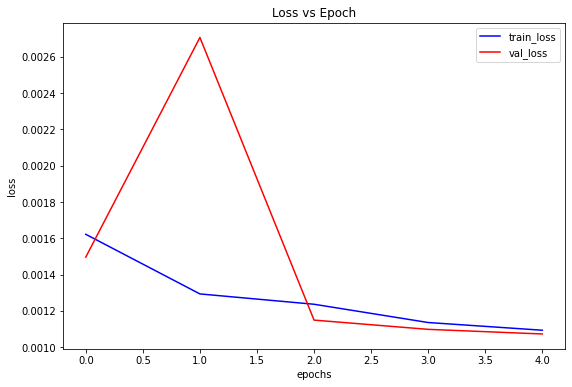

In [24]:
plt.rcParams['figure.figsize'] = (9,6)
plt.plot(range(epochs), train_loss_list, 'b', label='train_loss')
plt.plot(range(epochs), test_loss_list1, 'r', label='val_loss')

plt.title('Loss vs Epoch')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [27]:
device = 'cuda'
model = Network().to(device)
model = model.double()
model.load_state_dict(torch.load("uniquename_4.pth", map_location=device))
model.eval()

def classify(file_path):

    plt.figure()
    toImg = transforms.ToPILImage()
    index = 10

    image = io.imread(file_path)
    trf = transforms.Compose([SquarePad(256), Resize(256), ToTensor()])
    image = trf(image)
    norm = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    iamge = norm(image)
    Y = model(image.unsqueeze(0).to(device))

    for i in range(len(Y)):
        #inx = np.zeros((16, 2))
        a_list = []
        for a in range(len(Y[i])):
            b_list = []
            for b in range(len(Y[i][a])):
                max = Y[i][a][b].argmax().item()
        
                x = (max // 64) * 4
                y = (max % 64) * 4
        
                b_list.append((x,y))
            a_list.append(b_list)
        max_idx = torch.from_numpy(np.asarray(a_list)).to(device)
        break

    show_landmarks(toImg(image.type(torch.FloatTensor)), (max_idx.squeeze().to("cpu").numpy()))
    plt.show()

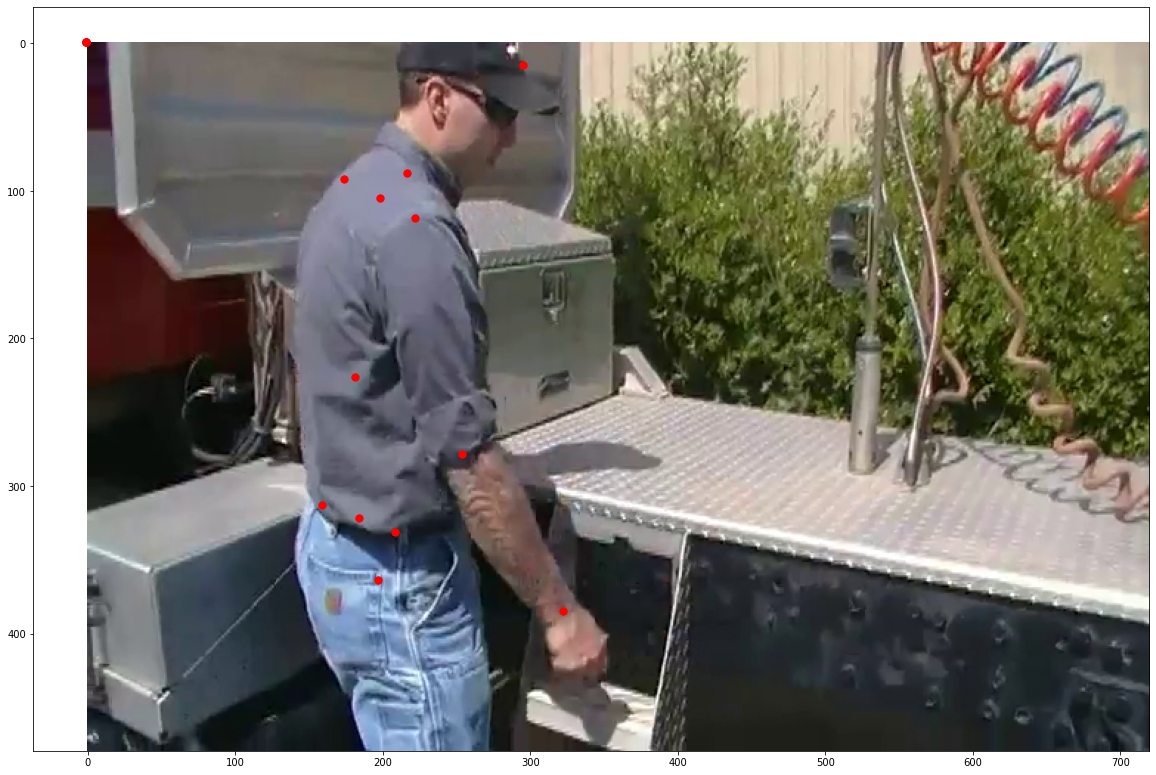

0

In [28]:
classify('images/069872692.jpg')